# Sales Analysis for AAL

## Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statistics
import statsmodels
import statsmodels.stats.stattools
from statsmodels.stats.stattools import medcouple
from statsmodels.stats.stattools import robust_skewness
from statsmodels.stats.stattools import robust_kurtosis

## Importing the source file to a pandas dataframe

In [3]:
sales_data_df=pd.read_csv('AusApparalSales4thQrt2020.csv')
sales_data_df.head()

,Date,Time,State,Group,Unit,Sales
0,1-Oct-2020,Morning,WA,Kids,8,20000
1,1-Oct-2020,Morning,WA,Men,8,20000
2,1-Oct-2020,Morning,WA,Women,4,10000
3,1-Oct-2020,Morning,WA,Seniors,15,37500
4,1-Oct-2020,Afternoon,WA,Kids,3,7500


## Checking the dataset

In [4]:
sales_data_df.shape

(7560, 6)

In [5]:
sales_data_df.describe()

,Unit,Sales
count,7560.000000,7560.000000
mean,18.005423,45013.558201
std,12.901403,32253.506944
min,2.000000,5000.000000
25%,8.000000,20000.000000
50%,14.000000,35000.000000
75%,26.000000,65000.000000
max,65.000000,162500.000000


In [6]:
sales_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    7560 non-null   object
 1   Time    7560 non-null   object
 2   State   7560 non-null   object
 3   Group   7560 non-null   object
 4   Unit    7560 non-null   int64 
 5   Sales   7560 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 354.5+ KB


In [7]:
sales_data_df.memory_usage()

Index      132
Date     60480
Time     60480
State    60480
Group    60480
Unit     60480
Sales    60480
dtype: int64

## Data Wrangling

## Converting object datatypes into respective datatypes

In [8]:
sales_data_df['Date']=pd.to_datetime(sales_data_df['Date'])
cols=list(sales_data_df.select_dtypes(np.object_).columns)
sales_data_df[cols]=sales_data_df[cols].astype('string')
sales_data_df.dtypes

Date     datetime64[ns]
Time     string[python]
State    string[python]
Group    string[python]
Unit              int64
Sales             int64
dtype: object

### Checking for null values

In [9]:
sales_data_df.isna().sum()

Date     0
Time     0
State    0
Group    0
Unit     0
Sales    0
dtype: int64

In [10]:
sales_data_df.notna().sum()

Date     7560
Time     7560
State    7560
Group    7560
Unit     7560
Sales    7560
dtype: int64

### Checking unique values in each column

In [11]:
print(sales_data_df['Time'].unique())
print(sales_data_df['State'].unique())
print(sales_data_df['Group'].unique())
print(sales_data_df['Unit'].unique())


<StringArray>
[' Morning', ' Afternoon', ' Evening']
Length: 3, dtype: string
<StringArray>
[' WA', ' NT', ' SA', ' VIC', ' QLD', ' NSW', ' TAS']
Length: 7, dtype: string
<StringArray>
[' Kids', ' Men', ' Women', ' Seniors']
Length: 4, dtype: string
[ 8  4 15  3 10 11 13  5  6  9 14 12 16 28 21 29 22 32 49 36 34 26 31 27
 43 50 44 20 18 19 39 17 23 40 30  7 33 42 46 48 37 25 35 45 47 38 41 24
  2 51 63 62 52 56 59 64 53 61 54 60 55 65 57 58]


### Checking if there are duplicate entries

In [12]:
print(sales_data_df[sales_data_df.duplicated()])

Empty DataFrame
Columns: [Date, Time, State, Group, Unit, Sales]
Index: []


### Sorting values by state,Group

In [13]:
sales_data_df=sales_data_df.sort_values(by=['State','Time','Group'])
sales_data_df.head()

,Date,Time,State,Group,Unit,Sales
64,2020-10-01,Afternoon,NSW,Kids,40,100000
148,2020-10-02,Afternoon,NSW,Kids,33,82500
232,2020-10-03,Afternoon,NSW,Kids,18,45000
316,2020-10-04,Afternoon,NSW,Kids,26,65000
400,2020-10-05,Afternoon,NSW,Kids,35,87500


In [14]:
sales_data_df.tail()

,Date,Time,State,Group,Unit,Sales
7142,2020-12-26,Morning,WA,Women,14,35000
7226,2020-12-27,Morning,WA,Women,14,35000
7310,2020-12-28,Morning,WA,Women,8,20000
7394,2020-12-29,Morning,WA,Women,9,22500
7478,2020-12-30,Morning,WA,Women,13,32500


In [15]:
sales_data_df=sales_data_df.reset_index(drop=True)
sales_data_df.head()

,Date,Time,State,Group,Unit,Sales
0,2020-10-01,Afternoon,NSW,Kids,40,100000
1,2020-10-02,Afternoon,NSW,Kids,33,82500
2,2020-10-03,Afternoon,NSW,Kids,18,45000
3,2020-10-04,Afternoon,NSW,Kids,26,65000
4,2020-10-05,Afternoon,NSW,Kids,35,87500


## Checking for outliers

#### Outlier Detection - Univarite - Boxplot

<Axes: >

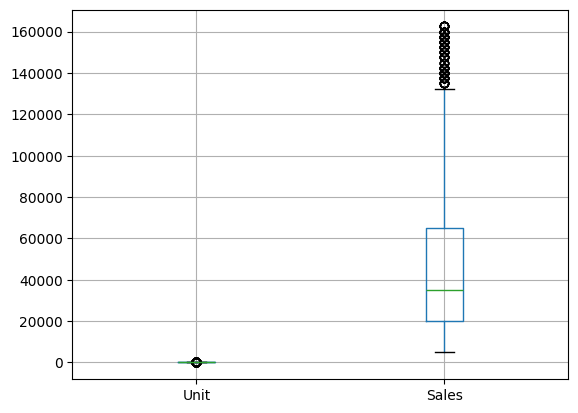

In [16]:
sales_data_df.boxplot()

### Since scale is different for both variable  let us analyse more using sea born plots.

### Plotting using seaborn to understand more 

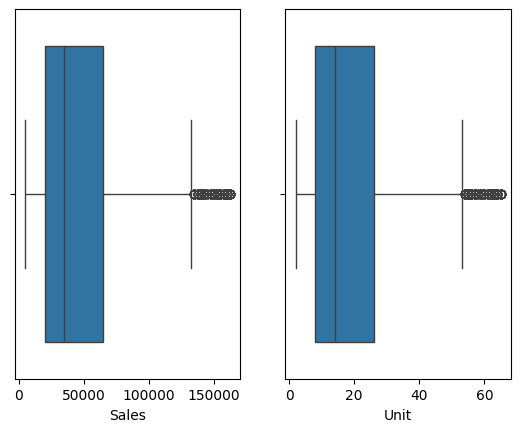

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.subplot(1,2,1)
sns.boxplot(x=sales_data_df['Sales'])
plt.subplot(1,2,2)
sns.boxplot(x=sales_data_df['Unit'])
plt.show()

### Using IQR (Interquartile range ) technique for outlier treatment

In [18]:
def outlier_treatment(col):
    sorted(col)
    Q1,Q3 = np.percentile(col , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

### Finding lower and upper limit in sales data

In [19]:
lower_sales_range,upper_sales_range = outlier_treatment(sales_data_df['Sales'])
print("Lower Range:",lower_sales_range)
print("Upper Range:",upper_sales_range)

Lower Range: -47500.0
Upper Range: 132500.0


### Finding number of outliers in sales data

In [20]:
lower_sales_df = sales_data_df[sales_data_df['Sales'].values < lower_sales_range]
lower_sales_df

,Date,Time,State,Group,Unit,Sales


In [21]:
upper_sales_df = sales_data_df[sales_data_df['Sales'].values > upper_sales_range]
upper_sales_df

,Date,Time,State,Group,Unit,Sales
5463,2020-12-04,Afternoon,VIC,Kids,54,135000
5466,2020-12-07,Afternoon,VIC,Kids,63,157500
5467,2020-12-08,Afternoon,VIC,Kids,62,155000
5468,2020-12-09,Afternoon,VIC,Kids,56,140000
5469,2020-12-10,Afternoon,VIC,Kids,57,142500
...,...,...,...,...,...,...
6464,2020-12-15,Morning,VIC,Women,61,152500
6468,2020-12-19,Morning,VIC,Women,57,142500
6471,2020-12-22,Morning,VIC,Women,56,140000
6475,2020-12-26,Morning,VIC,Women,54,135000


### Finding lower and upper limit in Units data

In [22]:
lower_unit_range,upper_unit_range = outlier_treatment(sales_data_df['Unit'])
print("Lower Range:",lower_unit_range)
print("Upper Range:",upper_unit_range)

Lower Range: -19.0
Upper Range: 53.0


### Finding outliers in units data

In [23]:
lower_unit_df = sales_data_df[sales_data_df['Unit'].values < lower_unit_range]
lower_unit_df

,Date,Time,State,Group,Unit,Sales


In [24]:
upper_unit_df = sales_data_df[sales_data_df['Unit'].values > upper_unit_range]
upper_unit_df

,Date,Time,State,Group,Unit,Sales
5463,2020-12-04,Afternoon,VIC,Kids,54,135000
5466,2020-12-07,Afternoon,VIC,Kids,63,157500
5467,2020-12-08,Afternoon,VIC,Kids,62,155000
5468,2020-12-09,Afternoon,VIC,Kids,56,140000
5469,2020-12-10,Afternoon,VIC,Kids,57,142500
...,...,...,...,...,...,...
6464,2020-12-15,Morning,VIC,Women,61,152500
6468,2020-12-19,Morning,VIC,Women,57,142500
6471,2020-12-22,Morning,VIC,Women,56,140000
6475,2020-12-26,Morning,VIC,Women,54,135000


### Finding which state has outlier data

In [25]:
upper_sales_df['State'].unique()

<StringArray>
[' VIC']
Length: 1, dtype: string

### Using normalization technique Min-Max Scaling and Z- score standardization

In [26]:
std_scaler = StandardScaler()

sales_data_df['normalized_Unit_std'] = std_scaler.fit_transform(sales_data_df[['Unit']])

sales_data_df['normalized_Sales_std'] = std_scaler.fit_transform(sales_data_df[['Sales']])

sales_data_df.describe()

,Date,Unit,Sales,normalized_Unit_std,normalized_Sales_std
count,7560,7560.000000,7560.000000,7.560000e+03,7.560000e+03
mean,2020-11-15 04:00:00.000000256,18.005423,45013.558201,6.015177e-17,7.518971e-18
min,2020-10-01 00:00:00,2.000000,5000.000000,-1.240678e+00,-1.240678e+00
25%,2020-10-23 00:00:00,8.000000,20000.000000,-7.755812e-01,-7.755812e-01
50%,2020-11-15 12:00:00,14.000000,35000.000000,-3.104847e-01,-3.104847e-01
75%,2020-12-08 00:00:00,26.000000,65000.000000,6.197082e-01,6.197082e-01
max,2020-12-30 00:00:00,65.000000,162500.000000,3.642835e+00,3.642835e+00
std,NaN,12.901403,32253.506944,1.000066e+00,1.000066e+00


In [27]:

scaler = MinMaxScaler()

sales_data_df['normalized_Unit'] = scaler.fit_transform(sales_data_df[['Unit']])

sales_data_df['normalized_Sales'] = scaler.fit_transform(sales_data_df[['Sales']])

sales_data_df.describe()

,Date,Unit,Sales,normalized_Unit_std,normalized_Sales_std,normalized_Unit,normalized_Sales
count,7560,7560.000000,7560.000000,7.560000e+03,7.560000e+03,7560.000000,7560.000000
mean,2020-11-15 04:00:00.000000256,18.005423,45013.558201,6.015177e-17,7.518971e-18,0.254054,0.254054
min,2020-10-01 00:00:00,2.000000,5000.000000,-1.240678e+00,-1.240678e+00,0.000000,0.000000
25%,2020-10-23 00:00:00,8.000000,20000.000000,-7.755812e-01,-7.755812e-01,0.095238,0.095238
50%,2020-11-15 12:00:00,14.000000,35000.000000,-3.104847e-01,-3.104847e-01,0.190476,0.190476
75%,2020-12-08 00:00:00,26.000000,65000.000000,6.197082e-01,6.197082e-01,0.380952,0.380952
max,2020-12-30 00:00:00,65.000000,162500.000000,3.642835e+00,3.642835e+00,1.000000,1.000000
std,NaN,12.901403,32253.506944,1.000066e+00,1.000066e+00,0.204784,0.204784


In [28]:
sales_data_df.describe()

,Date,Unit,Sales,normalized_Unit_std,normalized_Sales_std,normalized_Unit,normalized_Sales
count,7560,7560.000000,7560.000000,7.560000e+03,7.560000e+03,7560.000000,7560.000000
mean,2020-11-15 04:00:00.000000256,18.005423,45013.558201,6.015177e-17,7.518971e-18,0.254054,0.254054
min,2020-10-01 00:00:00,2.000000,5000.000000,-1.240678e+00,-1.240678e+00,0.000000,0.000000
25%,2020-10-23 00:00:00,8.000000,20000.000000,-7.755812e-01,-7.755812e-01,0.095238,0.095238
50%,2020-11-15 12:00:00,14.000000,35000.000000,-3.104847e-01,-3.104847e-01,0.190476,0.190476
75%,2020-12-08 00:00:00,26.000000,65000.000000,6.197082e-01,6.197082e-01,0.380952,0.380952
max,2020-12-30 00:00:00,65.000000,162500.000000,3.642835e+00,3.642835e+00,1.000000,1.000000
std,NaN,12.901403,32253.506944,1.000066e+00,1.000066e+00,0.204784,0.204784


#### Inference Min max scaler normalization is better in this scenario

#### Dropping z score normalized columns

In [29]:
sales_data_df=sales_data_df.drop(['normalized_Unit_std','normalized_Sales_std'],axis=1)
sales_data_df.head()

,Date,Time,State,Group,Unit,Sales,normalized_Unit,normalized_Sales
0,2020-10-01,Afternoon,NSW,Kids,40,100000,0.603175,0.603175
1,2020-10-02,Afternoon,NSW,Kids,33,82500,0.492063,0.492063
2,2020-10-03,Afternoon,NSW,Kids,18,45000,0.253968,0.253968
3,2020-10-04,Afternoon,NSW,Kids,26,65000,0.380952,0.380952
4,2020-10-05,Afternoon,NSW,Kids,35,87500,0.523810,0.523810


#### Descriptive statistical analysis on the data in the Sales and Unit columns. 

In [30]:
sales_data_df.describe()

,Date,Unit,Sales,normalized_Unit,normalized_Sales
count,7560,7560.000000,7560.000000,7560.000000,7560.000000
mean,2020-11-15 04:00:00.000000256,18.005423,45013.558201,0.254054,0.254054
min,2020-10-01 00:00:00,2.000000,5000.000000,0.000000,0.000000
25%,2020-10-23 00:00:00,8.000000,20000.000000,0.095238,0.095238
50%,2020-11-15 12:00:00,14.000000,35000.000000,0.190476,0.190476
75%,2020-12-08 00:00:00,26.000000,65000.000000,0.380952,0.380952
max,2020-12-30 00:00:00,65.000000,162500.000000,1.000000,1.000000
std,NaN,12.901403,32253.506944,0.204784,0.204784


In [31]:
skewness = medcouple(sales_data_df['Sales'])
skewness

array(0.38461538)

In [32]:
kurtosis  = robust_kurtosis(sales_data_df['Sales'])
kurtosis

(np.float64(0.6601863165793382),
 np.float64(-0.06642844881855048),
 np.float64(-0.2503192361713298),
 np.float64(-0.3502913961146086))

<Axes: xlabel='Sales', ylabel='Density'>

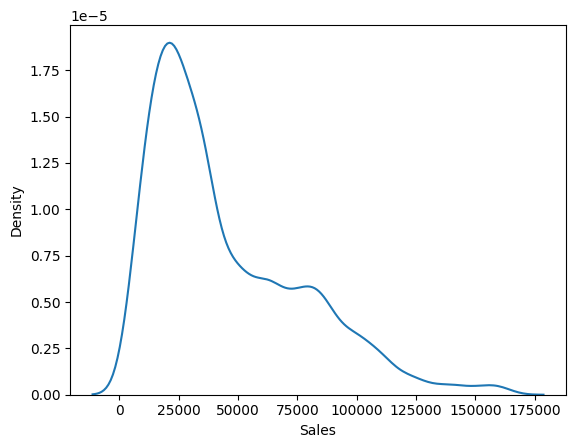

In [33]:
sns.kdeplot(data=sales_data_df['Sales'])

### Data is slightly positively skewed

In [34]:
correlation= sales_data_df['Sales'].corr(sales_data_df['Unit'],method='pearson')
print(correlation)

1.0


#### There is a perfect positive linear relationship between number of units sold and sales

#### Using group by to find the states with max and min sales

In [35]:
state_wise_sale=sales_data_df.groupby('State')['Sales'].sum()
state_max_sale=state_wise_sale.idxmax()
state_min_sale=state_wise_sale.idxmin()
print('State with maximum sales:',state_max_sale)
print('State with minimum sales:',state_min_sale)

State with maximum sales:  VIC
State with minimum sales:  WA


#### Here VIC is having the maximum sales in 4th quarter and WA is having the minimum sales

#### Checking which group is having minimum and maximum sales

In [36]:
group_wise_sale=sales_data_df.groupby('Group')['Sales'].sum()
group_max_sale=group_wise_sale.idxmax()
group_min_sale=group_wise_sale.idxmin()
print('Group with maximum sales:',group_max_sale)
print('Group with minimum sales:',group_min_sale)

Group with maximum sales:  Men
Group with minimum sales:  Seniors


#### Men apparels is having maximum sales and Seniors apparels is having minimum sales

#### Generating weekly,monthly,Quarterly reports

### Weekly Report

In [37]:

sales_data_df.set_index('Date',inplace=True)
weekly_report=sales_data_df.groupby([pd.Grouper(freq='W'),'Time','State','Group'])[['Unit','Sales']].sum()
weekly_report

Unit   Sales
Date       Time      State Group                
2020-10-04 Afternoon NSW   Kids      117  292500
                           Men       106  265000
                           Seniors   109  272500
                           Women     123  307500
                     NT    Kids       34   85000
...                                  ...     ...
2021-01-03 Morning   VIC   Women     134  335000
                     WA    Kids       25   62500
                           Men        35   87500
                           Seniors    29   72500
                           Women      30   75000

[1176 rows x 2 columns]

### Monthly Report

In [38]:
monthly_report=sales_data_df.groupby([pd.Grouper(freq='ME'),'Time','State','Group'])[['Unit','Sales']].sum()
monthly_report

Unit    Sales
Date       Time      State Group                 
2020-10-31 Afternoon NSW   Kids      801  2002500
                           Men       820  2050000
                           Seniors   758  1895000
                           Women     902  2255000
                     NT    Kids      285   712500
...                                  ...      ...
2020-12-31 Morning   VIC   Women    1336  3340000
                     WA    Kids      302   755000
                           Men       309   772500
                           Seniors   296   740000
                           Women     309   772500

[252 rows x 2 columns]

### Quarterly Report

In [39]:

quarterly_report=sales_data_df.groupby([pd.Grouper(freq='QE'),'Time','State','Group'])[['Unit','Sales']].sum()
quarterly_report

Unit    Sales
Date       Time      State Group                 
2020-12-31 Afternoon NSW   Kids     2475  6187500
                           Men      2605  6512500
                           Seniors  2394  5985000
                           Women    2570  6425000
                     NT    Kids      752  1880000
...                                  ...      ...
           Morning   VIC   Women    3519  8797500
                     WA    Kids      737  1842500
                           Men       803  2007500
                           Seniors   780  1950000
                           Women     707  1767500

[84 rows x 2 columns]

### Data Visualization

## Dashboard for Sales Analysis

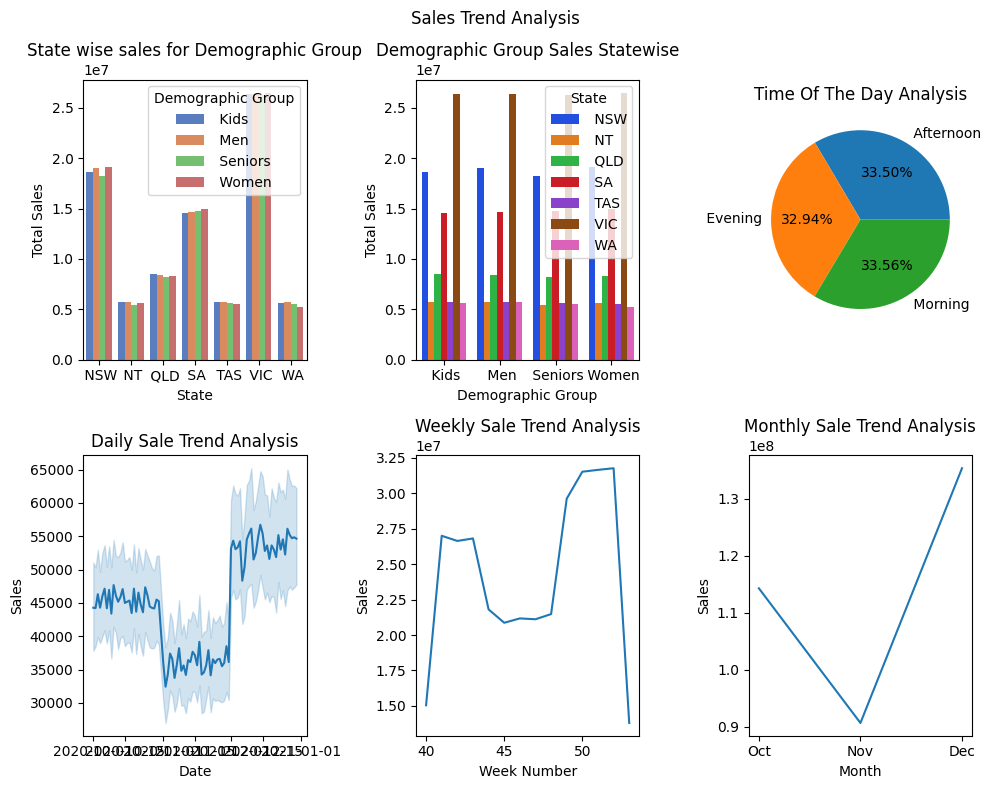

In [52]:
plt.figure(figsize=(10,8))
plt.suptitle('Sales Trend Analysis')

###State wise sales for Demographic Group
plt.subplot(231)
sns.barplot(x='State',y='Sales',hue='Group',data=sales_data_df,estimator=sum,palette='muted',errorbar=None,dodge=True)
plt.xlabel('State') 
plt.ylabel('Total Sales') 
plt.title('State wise sales for Demographic Group')
plt.legend(title='Demographic Group') 

### Demographic Group Sales Statewise
plt.subplot(232)
sns.barplot(x='Group',y='Sales',hue='State',data=sales_data_df,estimator=sum,palette='bright',errorbar=None,dodge=True)
plt.xlabel('Demographic Group') 
plt.ylabel('Total Sales') 
plt.title('Demographic Group Sales Statewise')

###Time Of the Day Analysis
plt.subplot(233)
grouped_data_time=sales_data_df.groupby(['Time'],as_index=False)['Sales'].sum()
plt.pie(grouped_data_time['Sales'],labels=grouped_data_time['Time'],autopct='%1.2f%%')
sales_data_df['Month']=sales_data_df.index.strftime('%b')
plt.title('Time Of The Day Analysis')

### Daily Sale Trend Analysis
plt.subplot(234)
sns.lineplot(x='Date',y='Sales',data=sales_data_df)
plt.title('Daily Sale Trend Analysis')

### Weekly Sale Trend Analysis
plt.subplot(235)
sales_data_df['Week Number']=sales_data_df.index.isocalendar().week
weekly_data=sales_data_df.groupby(['Week Number'],as_index=False)['Sales'].sum()
sns.lineplot(x='Week Number',y='Sales',data=weekly_data)
plt.title('Weekly Sale Trend Analysis')

### Monthly Sale Trend Analysis
plt.subplot(236)
monthly_data=sales_data_df.groupby(['Month'],as_index=False)['Sales'].sum()
monthly_data=monthly_data.sort_index(ascending=False)
sns.lineplot(x='Month',y='Sales',data=monthly_data)
plt.title('Monthly Sale Trend Analysis')

plt.tight_layout()
plt.show()

#### Below are the inferences from the dashboard
I have used Bar plot for plotting Statewise and Group wise sales. This plot clearly shows state VIC has most sales and the states with lowest sales are WA,TAS and NT. The sales for all groups are less in these states. 
I have used pie chart to determine the sales according the time of the day and could see afternoon time had slightly less sales compared to morning and evening times. 
I have uses line chart to plot the sales trend over the time. From the chart it is clear November month has lowest sale and December has most sales may be because of the Christmas holidays and from weekly trend it is showing sales are decreasing towards the end of December.